In [1]:
from refine import *
import project
import time
import prody as pdy
import mdtraj as mdt
import matplotlib.pyplot as plt
import logging

%pylab inline
project.setup()
# величины амплитуд смещений (трансляций, вращение и моды (моды можно тоже по отдельности смотреть))
# График энергии энергии в log scale
# подобрать границы rmsd

Populating the interactive namespace from numpy and matplotlib


/home/semyon/mipt/GPCR-TEAM/env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['degrees', 'byte', 'sum', 'tanh', 'sinh', 'tan', 'dot', 'bar', 'sin', 'cos', 'cosh', 'sqrt', 'bytes', 'radians', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
    logger = logging.getLogger('confined_descent')
    handler = logging.StreamHandler()
    handler.setLevel(logging.INFO)
    formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
    handler.setFormatter(formatter)
    logger.addHandler(handler)
    logger.setLevel(logging.ERROR)

In [3]:
def confined_gradient_descent(
        rw, decrement=0.9, relative_bounds_r=(0.01, 3), relative_bounds_s=(0.01, 0.5),
        max_iter=100, save_path=False, extended_result=False, log=False, soft_only=False):
    """
    Performs gradient descent with respect to a special confinement.

    @param rw: system to optimize.
    @type rw: RMRestrictionWrapper
    @param decrement: fold step when choosing optimal step.
    @type decrement: float
    @param relative_bounds_r: minimum and maximum rmsd between actual intermediate state and the next one (rigid).
    @type relative_bounds_r: tuple
    @param relative_bounds_s: minimum and maximum rmsd between actual intermediate state and the next one (modes).
    @type relative_bounds_s: tuple
    @param max_iter: maximum number of iterations
    @type max_iter: int
    @param save_path: if true all intermediate states, energies and forces are returned.
        Otherwise, the function returns only final record.
    @type save_path: bool
    @return: dictionary containing all the results.
        "states" - list of all states along optimization path.
        "energies" - list of all energies along optimization path.
        "forces" - list of all forces along optimization path.
        If return_traj is false returns only last record.
    @rtype: dict
    """
    if log:
        logger.setLevel(logging.INFO)
    else:
        logger.setLevel(logging.ERROR)

    
    logger.info("INITIALIZATION SATGE")
    optimization_result = {
        "positions": [],
        "energies": [],
        "forces": [],
        "coords": [],
        "success": True,
    }
    
    optimization_result["positions"].append(rw.get_position(0))
    optimization_result["energies"].append(rw.get_energy())
    optimization_result["forces"].append(rw.get_force(0))
    optimization_result["coords"].append(rw._protein_complex.get_coords(0))
    
    if extended_result:
        optimization_result["translation_diff"] = []
        optimization_result["rotation_diff"] = []
        optimization_result["mode_diff"] = []
        optimization_result["rigid_rmsd"] = []
        optimization_result["soft_rmsd"] = []
    
    k = 0
    while k < max_iter:
        logger.info(f"ITERATION {k} START")
        position = optimization_result["positions"][-1]
        energy = optimization_result["energies"][-1]
        force = optimization_result["forces"][-1]
        coords = optimization_result["coords"][-1]
        
        f_trans = force[0]
        torque = force[1]
        inertia_inv = np.linalg.inv(force[2])
        f_modes = force[3]
        w = np.sum(rw._weights[0])

        iinv_t = inertia_inv.dot(torque)
        iinv_t24 = iinv_t.dot(iinv_t) / 4
        ft24w = f_trans.dot(f_trans) / 4 / w
        tit = torque.dot(iinv_t)
        wrmsd20 = w * relative_bounds_r[0] ** 2
        wrmsd21 = w * relative_bounds_r[1] ** 2
        a = ft24w * iinv_t24
        b0 = ft24w + tit - wrmsd20 * iinv_t24
        c0 = -wrmsd20
        b1 = ft24w + tit - wrmsd21 * iinv_t24
        c1 = -wrmsd21
        roots0 = np.roots([a, b0, c0])
        roots1 = np.roots([a, b1, c1])
        tau0 = np.max(roots0) ** 0.25
        tau1 = np.max(roots1) ** 0.25
        logger.info(f"tau: {tau0}, {tau1}")

        mcoeff = (4 * w / f_modes.dot(f_modes)) ** 0.25
        mtau0 = relative_bounds_s[0] ** 0.5 * mcoeff
        mtau1 = relative_bounds_s[1] ** 0.5 * mcoeff
        logger.info(f"mtau: {mtau0}, {mtau1}")
        
        logger.info("LINEAR SEARCH")
        while tau1 > tau0 and mtau1 > mtau0:
            tdiff = tau1 ** 2 / w / 2 * f_trans
            qdiff = np.quaternion(1, *(tau1 ** 2 / 2 * iinv_t))
            qdiff /= qdiff.norm()
            mdiff = mtau1 ** 2 / 2 * f_modes
            
            if not soft_only:
                trans = tdiff + position[0]
                modes = mdiff + position[2]
            quat = qdiff * position[1]
            new_pos = [trans, quat, modes]
            
            # rmsd
            if extended_result:
                logger.info(f"EXT::tdiff: {tdiff}")
                logger.info(f"EXT::qdiff: {qdiff}")
                logger.info(f"EXT::mdiff: {mdiff}")
                coords1 = coords
                test_pos = [trans, quat, position[2]]
                rw.set_position(0, test_pos)
                coords2 = rw._protein_complex.get_coords(0)
                weights = rw._weights[0]
                rrmsd = rmsd(coords1, coords2, weights)
                logger.info(f"EXT::RRMSD: {rrmsd}")
                srmsd = ((mdiff.dot(mdiff)) / np.sum(weights)) ** 0.5
                logger.info(f"EXT::SRMSD: {srmsd}")
            
            rw.set_position(0, new_pos)
            new_energy = rw.get_energy()
            tau1 *= decrement * decrement
            mtau1 *= decrement * decrement
            logger.info(new_energy)
            if new_energy < energy:
                break;
        if extended_result:
            optimization_result["translation_diff"].append(tdiff)
            optimization_result["rotation_diff"].append(qdiff)
            optimization_result["mode_diff"].append(mdiff)
            optimization_result["rigid_rmsd"].append(rrmsd)
            optimization_result["soft_rmsd"].append(srmsd)
            
        logger.info(f"ITERATION {k} END")
        optimization_result["energies"].append(rw.get_energy())
        if optimization_result["energies"][-2] < optimization_result["energies"][-1]:
            optimization_result["energies"].pop()
            optimization_result["success"] = False
            break
        optimization_result["positions"].append(rw.get_position(0))
        optimization_result["forces"].append(rw.get_force(0))
        optimization_result["coords"].append(rw._protein_complex.get_coords(0))
        if not save_path:
            optimization_result["positions"].pop(0)
            optimization_result["forces"].pop(0)
            optimization_result["coords"].pop(0)
            optimization_result["energies"].pop(0)
        k += 1
    return optimization_result

In [4]:
def distance(A, B):
    n = len(A)
    m = len(B)
    darr = []
    for i in range(len(A)):
        for j in range(len(B)):
            diff = A[i] - B[j]
            darr.append(np.linalg.norm(diff))
    darr = np.array(darr)
    return np.min(darr)

def np_distance_matrix(A, B):
    n = len(A)
    m = len(B)
    mA = np.stack([A.copy() for i in range(m)], 0)
    mB = np.swapaxes(np.stack([B.copy() for i in range(n)], 0), 0, 1)
    dist = np.apply_along_axis(np.linalg.norm, 2, mA-mB)
    return dist

def np_set_distance(A, B):
    return np.min(np_distance_matrix(A, B))

A = np.array([[2, 0], [1, 0], [0, 0], [4, 1]])
B = np.array([[-1, 0], [4, 0], [2, 1], [2, 1], [4, 1.2]])

print(np_set_distance(A, B))
print(distance(A, B))

0.19999999999999996
0.19999999999999996


In [17]:
path = str(project.data_path / "benchmark" / "modeled" / "1dfj_modeled.pdb")
omm_struct = app.PDBFile(path)
chains = list(omm_struct.topology.chains())
selections = [f"chain {chain.id}" for chain in chains]
t0 = time.time()
pc = ProteinComplex(str(path), "charmm36.xml", selections)
print("construction of system:", -t0 + time.time(), "sec")

@> 8726 atoms and 1 coordinate set(s) were parsed in 0.06s.


construction of system: 10.442941665649414 sec


In [6]:
coords_0 = pc.get_coords(0)
coords_1 = pc.get_coords(1)

In [7]:
pc.set_coords(0, coords_0)
pc.set_coords(1, coords_1)

In [14]:
t0 = time.time()
mode_params = [
    {"nmodes": 10, "cutoff": 4.0},
    {"nmodes": 0}
]
rw = RMRestrictionWrapper(pc, mode_params)
print("construction of wrapper:", -t0 + time.time(), "sec")

@> Hessian was built in 0.40s.
@> 10 modes were calculated in 5.93s.


construction of wrapper: 6.381259918212891 sec


In [9]:
zero_pos = [np.array([0, 0, 0]), np.quaternion(1, 0, 0, 0), np.array([0] * 10)]

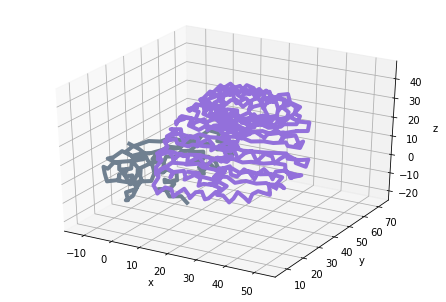

In [10]:
rw.set_position(0, zero_pos)
pdy.showProtein(rw._protein_complex._pdy_protein)
pylab.show()

In [15]:
# господин никто
# awakenings
# chernobl series
# energy test
t0 = time.time()
E = rw.get_energy()
t1 = time.time() - t0
print(f"energy was calculated in {t1} seconds")
print(E)

energy was calculated in 0.16468381881713867 seconds
12727.428514337755


In [12]:
# distance test
t0 = time.time()
dist = distance(pc.get_coords(0), pc.get_coords(1))
t1 = time.time() - t0
print(f"distance was calculated in {t1} seconds: {dist}")
t0 = time.time()
dist = np_set_distance(pc.get_coords(0), pc.get_coords(1))
t1 = time.time() - t0
print(f"distance was calculated in {t1} seconds: {dist}")

KeyboardInterrupt: 

In [13]:
print(rw.get_position(0))

[array([0, 0, 0]), quaternion(1, 0, 0, 0), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


In [14]:
pos0 = rw.get_position(0)
pos1 = rw.get_position(1)
rw.set_position(0, [np.array([0, 0, 0]), np.quaternion(np.cos(np.pi * (1/24)), 0, 0, np.sin(np.pi * (1/24))), (len(coords_0)) ** 0.5 * np.array([0.3, 0.1, 0.5, *([0] * 7)])])
rw.set_position(1, [np.array([0, 0, 0]), pos1[1], pos1[2]])

In [15]:
n = len(coords_0)
mode_pos = rw.get_position(0)[2]
rotation_matrix = quaternion.as_rotation_matrix(rw.get_position(0)[1])
print(mode_pos)
i_tensor = rw._i_tensors[0]
c_tensor = rw._c_tensors[0]
d_tensor = rw._d_tensors[0]
f_tensor = rw._f_tensors[0]
weights = rw._weights[0]
print(i_tensor)
new_i_dir = build_i_tensor(rw._protein_complex.get_coords(0), c_tensor + rw.get_position(0)[0], weights)
new_i_ind = calc_inertia_tensor(rotation_matrix, mode_pos, i_tensor, d_tensor, f_tensor, weights)
print(new_i_dir)
print(new_i_ind)
print(np.linalg.norm(new_i_dir - new_i_ind))

[12.92439554  4.30813185 21.54065923  0.          0.          0.
  0.          0.          0.          0.        ]
[[231571.0675428  -61670.97733057 -38787.55221315]
 [-61670.97733057 280531.3453026  -21842.39742146]
 [-38787.55221315 -21842.39742146 274584.60673437]]
[[263919.179475   -63876.54833822 -31302.9235313 ]
 [-63876.54833822 245331.49752134 -32226.2359198 ]
 [-31302.9235313  -32226.2359198  275917.81667028]]
[[263919.179475   -63876.54833822 -31302.9235313 ]
 [-63876.54833822 245331.49752133 -32226.2359198 ]
 [-31302.9235313  -32226.2359198  275917.81667028]]
1.4678602078530929e-09


In [18]:
result = confined_gradient_descent(rw, save_path=True, log=True, extended_result=True)

confined_descent - INFO - INITIALIZATION SATGE
confined_descent - INFO - ITERATION 0 START
confined_descent - INFO - tau: 1.9236528312172886e-05, 0.00033406865797568763
confined_descent - INFO - mtau: 2.1919679511537846e-05, 0.0001549955402404424
confined_descent - INFO - LINEAR SEARCH
confined_descent - INFO - EXT::tdiff: [ 0.66664449 -0.58807397  0.53382345]
confined_descent - INFO - EXT::qdiff: quaternion(0.98806787852521, 0.0888682332879401, 0.00715005418918209, -0.061976284087324)
confined_descent - INFO - EXT::mdiff: [ -9.19599955 -15.96669394   5.62942051   1.98991992   7.00967393
   5.62146528  -0.17072397   1.77044558   1.46723416  -1.67192093]
confined_descent - INFO - EXT::RRMSD: 2.9999999999999982
confined_descent - INFO - EXT::SRMSD: 0.4999999999999999
confined_descent - INFO - 117278467095.67113
confined_descent - INFO - EXT::tdiff: [ 0.43738545 -0.38583533  0.35024156]
confined_descent - INFO - EXT::qdiff: quaternion(0.99482846860539, 0.0587053941285677, 0.00472324849596

confined_descent - INFO - EXT::RRMSD: 0.5590938077593733
confined_descent - INFO - EXT::SRMSD: 0.09265100944259208
confined_descent - INFO - 3.405030146262266e+18
confined_descent - INFO - EXT::tdiff: [-0.03193451  0.0573771  -0.06150413]
confined_descent - INFO - EXT::qdiff: quaternion(0.999812498945167, -0.0123498828134128, 0.00144648119721793, 0.0057318395675303)
confined_descent - INFO - EXT::mdiff: [ 0.82608418  1.37518397 -0.55323903  0.36856198 -1.49232792  1.05840651
 -0.19776039  0.04639815  0.18365631 -0.64854743]
confined_descent - INFO - EXT::RRMSD: 0.36686420717856716
confined_descent - INFO - EXT::SRMSD: 0.06078832729528469
confined_descent - INFO - 1.4697100843935165e+17
confined_descent - INFO - EXT::tdiff: [-0.02095223  0.03764512 -0.04035286]
confined_descent - INFO - EXT::qdiff: quaternion(0.999919278323948, -0.00810362348361568, 0.000949137670007135, 0.00376106157649608)
confined_descent - INFO - EXT::mdiff: [ 0.54199383  0.9022582  -0.36298013  0.24181352 -0.979116

In [17]:
print(result["energies"])

[1.555367763513607e+16, 7296985681801.12, 505174194042.58734, 64434978506.99593, 28237240669.486782, 22256729723.249607, 7944505137.950851, 2971613949.26062]


In [55]:
# native rmsd
pos = zero_pos
rw.set_position(0, pos)
coords_native = rw._protein_complex.get_coords(0)

pos = result["positions"][0]
rw.set_position(0, result["positions"][0])
coords_changed = rw._protein_complex.get_coords(0)

pos = result["positions"][-1]
# pos = [np.array([0, 0, 0]), pos[1], np.zeros((10,))]
rw.set_position(0, pos)
coords_refined = rw._protein_complex.get_coords(0)

pos = [np.array([0, 0, 0]), 
       np.quaternion(np.cos(np.pi * (1/24)), 0, 0, np.sin(np.pi * (1/24))), 
       (len(coords_0)) ** 0.5 * np.array([0.3, 0.1, 0.5, *([0] * 7)])]
rw.set_position(0, pos)
coords_super = rw._protein_complex.get_coords(0)

weights = rw._weights[0]
rmsd_nc = rmsd(coords_native, coords_changed, weights)
rmsd_nr = rmsd(coords_native, coords_refined, weights)
rmsd_ns = rmsd(coords_native, coords_super, weights)
rmsd_cs = rmsd(coords_changed, coords_super, weights)
print(f"Initial rmsd: {rmsd_nc}")
print(f"Final rmsd: {rmsd_nr}")
print(f"Super rmsd: {rmsd_ns}")
print(f"CS rmsd: {rmsd_cs}")

Initial rmsd: 4.715347969463472
Final rmsd: 2.0673849007924123
Super rmsd: 3.217314083336623
CS rmsd: 3.1018216180309577


In [42]:
position_refined = result["positions"][-1]
print(position_refined)

trmsd = (position_refined[0].dot(position_refined[0])) ** 0.5
srmsd = (position_refined[2].dot(position_refined[2]) / np.sum(weights)) ** 0.5
print(trmsd)
print(srmsd)


[array([ 0.8471501 ,  1.46897074, -0.37855093]), quaternion(0.972385942518937, 0.0150960379479378, 0.00227652860009025, 0.00793411561673362), array([ -9.73543365, -11.16972233,  17.90164954,  18.22993731,
        -4.82267052, -17.91364526, -15.59203983,  11.44176338,
        18.17818829,  12.91604492])]
1.737480683222477
1.0606079183975456


In [21]:
rw.set_position(0, zero_pos)
full_list = result["coords"]
full_list.insert(0, rw._protein_complex.get_coords(0))
n_states = len(full_list)

trj = None
for i in range(n_states):
    pc.set_coords(0, full_list[i])
    with open(project.output_path / "inter_pdb.pdb", "w") as input_file:
        pc._omm_protein.writeFile(positions=pc._omm_protein.positions,
                                   topology=pc._omm_protein.topology,
                                   file=input_file)
    if trj is not None:
        trj = trj.join(mdt.load(str(project.output_path / "inter_pdb.pdb")))
    else:
        trj = mdt.load(str(project.output_path / "inter_pdb.pdb"))
    print(trj.xyz.shape)

(1, 8726, 3)
(2, 8726, 3)
(3, 8726, 3)
(4, 8726, 3)
(5, 8726, 3)
(6, 8726, 3)
(7, 8726, 3)
(8, 8726, 3)
(9, 8726, 3)
(10, 8726, 3)
(11, 8726, 3)
(12, 8726, 3)
(13, 8726, 3)
(14, 8726, 3)
(15, 8726, 3)
(16, 8726, 3)
(17, 8726, 3)
(18, 8726, 3)
(19, 8726, 3)
(20, 8726, 3)
(21, 8726, 3)
(22, 8726, 3)
(23, 8726, 3)
(24, 8726, 3)
(25, 8726, 3)
(26, 8726, 3)
(27, 8726, 3)
(28, 8726, 3)
(29, 8726, 3)
(30, 8726, 3)
(31, 8726, 3)
(32, 8726, 3)
(33, 8726, 3)
(34, 8726, 3)
(35, 8726, 3)
(36, 8726, 3)
(37, 8726, 3)
(38, 8726, 3)
(39, 8726, 3)
(40, 8726, 3)
(41, 8726, 3)
(42, 8726, 3)
(43, 8726, 3)
(44, 8726, 3)
(45, 8726, 3)
(46, 8726, 3)
(47, 8726, 3)
(48, 8726, 3)
(49, 8726, 3)
(50, 8726, 3)
(51, 8726, 3)
(52, 8726, 3)
(53, 8726, 3)
(54, 8726, 3)
(55, 8726, 3)
(56, 8726, 3)
(57, 8726, 3)
(58, 8726, 3)
(59, 8726, 3)
(60, 8726, 3)
(61, 8726, 3)
(62, 8726, 3)
(63, 8726, 3)
(64, 8726, 3)


In [22]:
trj.save_pdb(str(project.output_path / "trajectory5.pdb"))

In [ ]:
step = -3
T = np.array([step, 0, 0])

ref_coords = pc.get_coords(1)
old_coords = pc.get_coords(0)

n = len(old_coords)
T_span = np.tile(T, n).reshape((n, 3))


X = [0]
E = [pc.get_energy()]
D = [distance(old_coords, ref_coords)]
for i in range(15):
    new_coords = old_coords + T_span
    old_coords = new_coords
    pc.set_coords(0, new_coords)
    E.append(pc.get_energy())
    D.append(distance(old_coords, ref_coords))
    X.append(step * (i + 1))
    print(i + 1, end=" ")
    

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X, E)
ax.set_yscale("linear")
ax.grid()
plt.show()

In [23]:
E

-10720.654358275733

In [24]:
E1 = result["energies"] - np.min(E) + 1
D1 = np.array([np.linalg.norm(v) for v in result["translation_diff"]])
D2 = np.array([np.linalg.norm(v) for v in result["rigid_rmsd"]])
D3 = np.array([np.linalg.norm(v) for v in result["soft_rmsd"]])

In [25]:
E1

array([3.14601210e+12, 3.61208221e+10, 6.95747769e+09, 9.14899985e+08,
       5.18650800e+08, 4.18154874e+08, 1.20394917e+08, 4.90209643e+07,
       3.65882262e+07, 1.55325564e+07, 1.53515568e+07, 1.21480116e+07,
       1.21081142e+07, 1.03113295e+07, 9.68526613e+06, 8.66129344e+06,
       7.96583364e+06, 7.04352935e+06, 6.48695824e+06, 5.64330763e+06,
       5.33969603e+06, 5.25830244e+06, 4.61681290e+06, 3.67792034e+06,
       3.47710841e+06, 3.34437186e+06, 2.87662025e+06, 2.55654505e+06,
       2.38273957e+06, 2.20797728e+06, 2.08822367e+06, 1.63923639e+06,
       1.54188029e+06, 1.50790164e+06, 1.41538809e+06, 1.39283473e+06,
       1.30323205e+06, 1.28659293e+06, 1.20022771e+06, 1.18607454e+06,
       1.10339255e+06, 1.08962087e+06, 1.01098594e+06, 9.96407225e+05,
       9.22124182e+05, 9.06256934e+05, 8.36650147e+05, 8.19636960e+05,
       8.14013147e+05, 7.59819350e+05, 7.05917462e+05, 6.89767848e+05,
       6.18289278e+05, 5.66994747e+05, 5.59753283e+05, 5.36939936e+05,
      

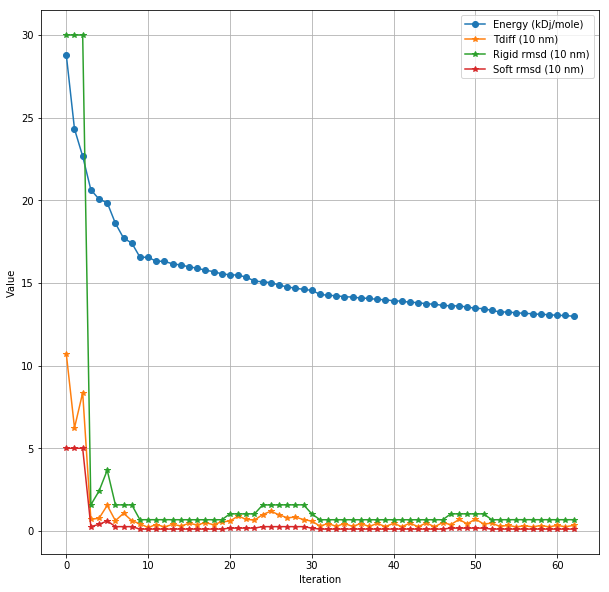

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
# plot(x, y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
ax.plot(range(len(E1)), np.log(E1), marker='o', label="Energy (kDj/mole)") # тобы точки было видно
ax.plot(range(len(D1)), 10*D1, marker='*', label="Tdiff (10 nm)")
ax.plot(range(len(D2)), 10*D2, marker='*', label="Rigid rmsd (10 nm)")
ax.plot(range(len(D3)), 10*D3, marker='*', label="Soft rmsd (10 nm)")
ax.set_yscale("linear")
ax.set_xlabel("Iteration")
ax.set_ylabel("Value")
ax.legend()
ax.grid()
plt.savefig(project.output_path / "plot", fmt="png")
plt.show()

In [27]:
rw._protein_complex.get_coords(0)

array([[ 86.94921098, -32.1553179 ,   2.57630454],
       [ 87.4318867 , -32.23419678,   1.63233754],
       [ 87.64700711, -32.37348674,   3.34214153],
       ...,
       [ 63.88739034, -30.9521773 ,  25.04640989],
       [ 62.22839047, -31.6021048 ,  25.07395235],
       [ 63.65730722, -33.87989076,  28.04677872]])

In [70]:
print(result)

{'positions': [[array([ 0.06258083,  1.44673025, -1.04684348]), array([ 0.9802652 , -0.10393313,  0.00633735,  0.13343592]), array([12.19425817,  2.26452367, 18.56486005,  2.96360493,  0.2255941 ,
       -5.89117046, 15.26653641,  6.9364498 , -9.71182438,  4.99610138])], [array([ 0.22653881,  2.24088776, -0.34921512]), array([ 0.97718794,  0.01238916, -0.00615622,  0.1437913 ]), array([ 5.33398102, -3.68695298, 27.36693576, 10.66587437,  2.89576387,
       -9.35179958,  3.47870191,  7.63700628, -0.6063815 ,  6.80063995])], [array([ 0.55976304,  2.09866834, -0.85710041]), array([ 0.97344999, -0.08693387,  0.00956435,  0.06712018]), array([  1.13466465,  -2.17872703,  18.74323523,   6.37895423,
        -8.8532542 , -13.68730218,   3.47397776,   6.42003982,
         9.78311835,  16.02486653])], [array([ 1.00109356,  2.56387904, -0.32114855]), array([ 0.97288891,  0.01276014, -0.00215135,  0.01419966]), array([ -2.94839573,  -5.52208321,  19.82644725,  12.14588377,
        -6.74554214, -18

In [73]:
# save session
name = "session_5.session"
import pickle
# for p in result["positions"]:
#     p[1] = quaternion.as_float_array(p[1])
# for f in result["forces"]:
#     f[1] = quaternion.as_float_array(f[1])
# result["rotation_diff"] = [quaternion.as_float_array(q) for q in result["rotation_diff"]]

with open(project.output_path / name, "wb") as output_file:
    pickle.dump({"coords0": rw._protein_complex.get_coords(0),
                 "coords1": rw._protein_complex.get_coords(1),
                 "initial_position": [np.array([0, 0, 0]), 
                                      np.array([np.cos(np.pi * (1/24)), 0, 0, np.sin(np.pi * (1/24))]),
                                      np.array([0.3, 0.1, 0.5, *([0] * 7)])],
                 "result": result}, output_file)

In [18]:
330/260 * 190 * 1.1

265.2692307692308